In [82]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import torch

In [83]:
dir = "../inputs/JSON/"

In [84]:
def find_closest_blue(yellow_x, yellow_y, x_blue, y_blue):
    distances = [distance.euclidean((yellow_x, yellow_y), (blue_x, blue_y)) for blue_x, blue_y in zip(x_blue, y_blue)]
    closest_blue_index = distances.index(min(distances))
    return x_blue[closest_blue_index], y_blue[closest_blue_index]

In [85]:
def calculate_midpoints(yellow_x, yellow_y, x_blue, y_blue):
    division_factors = [1, 2, 3]  # You can add more values if needed
    midpoints = []

    for factor in division_factors:
        closest_blue_x, closest_blue_y = find_closest_blue(yellow_x, yellow_y,x_blue, y_blue)
        midpoint_x = (yellow_x + closest_blue_x) / factor
        midpoint_y = (yellow_y + closest_blue_y) / factor
        midpoints.append((midpoint_x, midpoint_y))

    # Choose the midpoint that is most in the middle
    middle_index = len(midpoints) // 2  # Index of the middle value
    return midpoints[middle_index]

In [86]:
def plot_samples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones')
    plt.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones')
    plt.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')

    # Customize plot if needed
    plt.title('Midpoints between Blue and Yellow Cones')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [87]:
def generate_src_tgt():
    count = 0
    src = pd.DataFrame()
    tgt = pd.DataFrame()
    print("Showing Sample Data: ")
    for tracks in os.listdir(dir):
        if tracks.endswith(".json"):
            tracks = os.path.join(dir, tracks)
            #print(tracks)
            with open(tracks, 'r') as file:
                json_data = json.load(file)
            x_blue = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue"]
            y_blue = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue"]
            x_yellow = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
            y_yellow = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
            x_path, y_path = zip(*[calculate_midpoints(yellow_x, yellow_y,x_blue,y_blue) for yellow_x, yellow_y in zip(x_yellow, y_yellow)])
            midpoints = pd.DataFrame(list(zip(x_path, y_path)), columns=['x_target', 'y_target'])
            
            if count < 4:
                plot_samples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)                    
                count += 1
            
            src = pd.concat([src, pd.read_json(tracks)], axis=0)
            tgt = pd.concat([tgt, midpoints], axis=0)
            src.reset_index(drop=True, inplace=True)
            tgt.reset_index(drop=True, inplace=True)
    colors = pd.get_dummies(src['color'])
    src = pd.concat([src, colors], axis=1)
    src.drop('color', axis=1, inplace=True)
    src = torch.tensor(src.values, dtype=torch.float32)
    tgt = torch.tensor(tgt.values, dtype=torch.float32)
    print("Data loaded successfully!")
    return src, tgt

Showing Sample Data: 


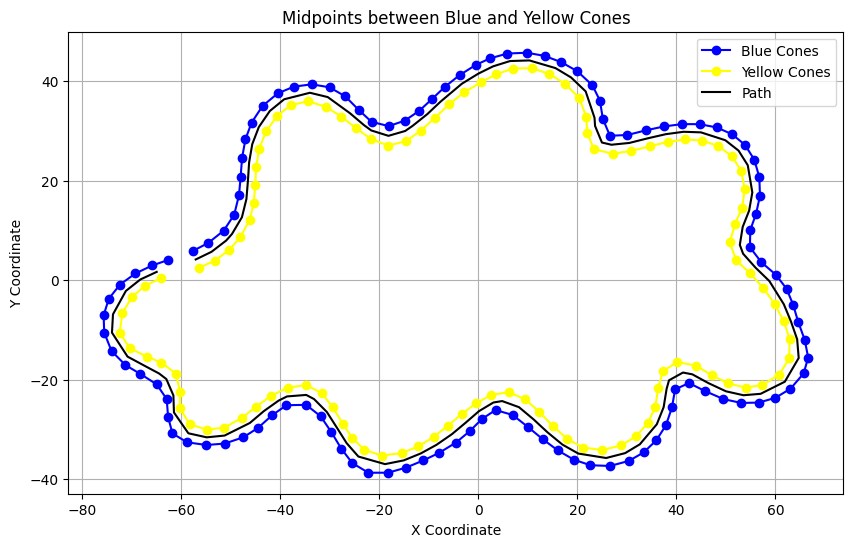

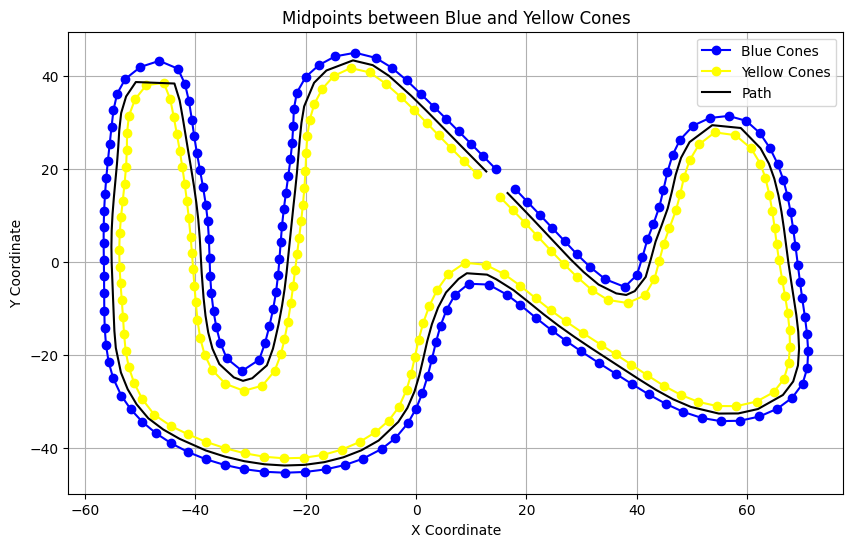

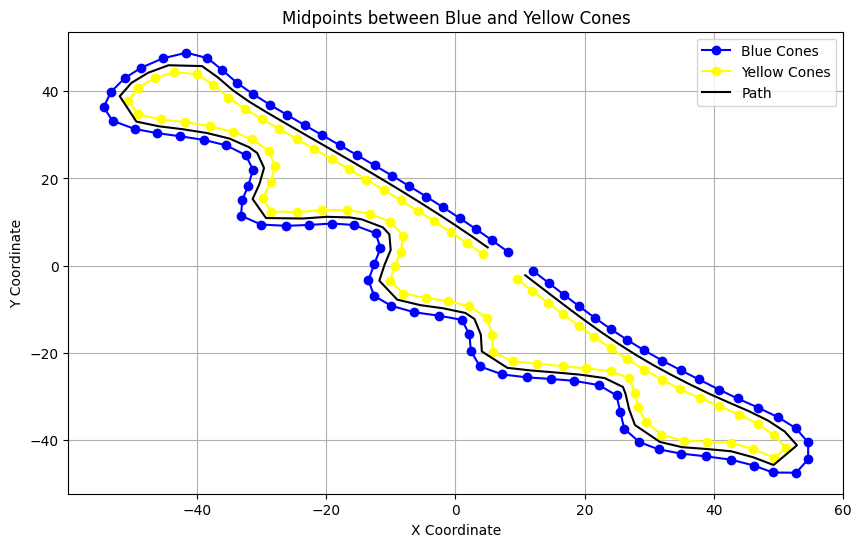

Data loaded successfully!


In [88]:
src,tgt = generate_src_tgt()

In [89]:
src.shape, tgt.shape

(torch.Size([694, 5]), torch.Size([335, 2]))